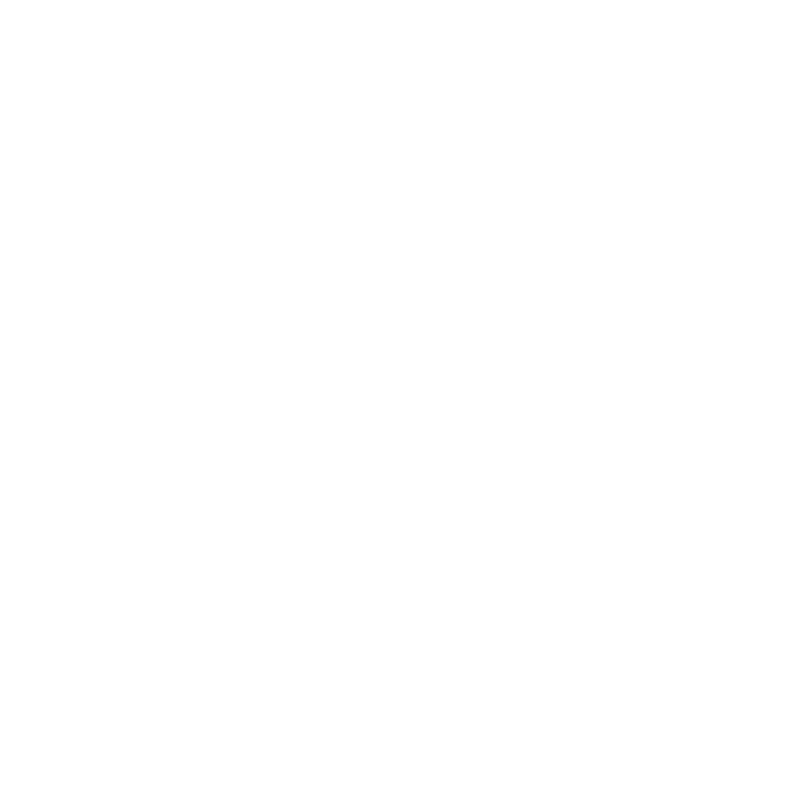

In [3]:

%widget
# Interactive SAM2 segmentation in a notebook (points & boxes)
# ------------------------------------------------------------
# Requirements (first time):
#   pip install transformers accelerate timm torch torchvision tifffile pillow ipywidgets matplotlib scipy
#   jupyter nbextension enable --py widgetsnbextension   # (Classic Notebook)
# If using JupyterLab ≥3, widgets should work out of the box.

from __future__ import annotations

import json
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional

import numpy as np
import tifffile
from PIL import Image
import torch
from transformers import Sam2Model, Sam2Processor
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ipywidgets import (
    HBox, VBox, Button, ToggleButtons, BoundedIntText, FloatSlider, Text, Dropdown,
    HTML, Checkbox
)
from IPython.display import display, clear_output

# -----------------------------
# Utilities: IO + preprocessing
# -----------------------------

def load_multispectral(path: Path) -> np.ndarray:
    arr = tifffile.imread(str(path))
    if arr.ndim == 2:
        arr = arr[np.newaxis, ...]
    if arr.shape[0] < arr.shape[-1]:
        # (C, H, W)
        return arr.astype(np.float32)
    # (H, W, C) -> (C, H, W)
    return np.transpose(arr, (2, 0, 1)).astype(np.float32)

def stretch_channel(ch: np.ndarray) -> np.ndarray:
    lo, hi = np.percentile(ch, (2, 98))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        denom = (np.nanmax(ch) or 1.0)
        return np.clip(ch / denom, 0.0, 1.0)
    return np.clip((ch - lo) / (hi - lo), 0.0, 1.0)

def build_rgb_composite(ms: np.ndarray, band_indices_1based: List[int]) -> np.ndarray:
    bands = []
    for idx in band_indices_1based:
        if not (1 <= idx <= ms.shape[0]):
            raise ValueError(f"Band {idx} out of range 1..{ms.shape[0]}")
        bands.append(stretch_channel(ms[idx - 1]))
    comp = np.stack(bands, axis=0)  # (3,H,W) float in [0,1]
    return np.transpose((comp * 255.0).astype(np.uint8), (1, 2, 0))  # (H,W,3) uint8

# Optional: a light vegetation index used only when "use veg seeding" is enabled.
def vegetation_index_from_rgb_uint8(rgb_uint8: np.ndarray) -> np.ndarray:
    r = rgb_uint8[..., 0].astype(np.float32) / 255.0
    g = rgb_uint8[..., 1].astype(np.float32) / 255.0
    b = rgb_uint8[..., 2].astype(np.float32) / 255.0
    exg = 2.0 * g - r - b
    exg = (exg - np.nanmin(exg)) / (np.nanmax(exg) - np.nanmin(exg) + 1e-6)
    return np.nan_to_num(exg, nan=0.0)

# -----------------------------
# SAM2 glue
# -----------------------------

def select_best_masks(post_masks: torch.Tensor, iou_scores: torch.Tensor) -> torch.Tensor:
    """
    post_masks: (num_objects, num_masks, H, W) bool
    iou_scores: (num_objects, num_masks)
    returns: (H, W) bool combined
    """
    if post_masks.shape[0] == 0:
        raise ValueError("SAM2 returned no masks.")
    best = []
    for o in range(post_masks.shape[0]):
        best_idx = int(torch.argmax(iou_scores[o]).item())
        best.append(post_masks[o, best_idx])
    return torch.stack(best, dim=0).any(dim=0)

# -----------------------------
# Prompts storage (interactive)
# -----------------------------

@dataclass
class ObjPrompts:
    points: List[List[float]] = field(default_factory=list)   # [[x,y], ...]
    labels: List[int] = field(default_factory=list)           # [1/0, ...]
    box: Optional[List[float]] = None                         # [x0,y0,x1,y1] optional

    def add_point(self, x: float, y: float, label: int):
        self.points.append([float(x), float(y)])
        self.labels.append(int(label))

    def set_box(self, x0: float, y0: float, x1: float, y1: float):
        self.box = [float(min(x0,x1)), float(min(y0,y1)), float(max(x0,x1)), float(max(y0,y1))]

class PromptManager:
    def __init__(self):
        self.by_obj: Dict[int, ObjPrompts] = {}

    def obj(self, oid: int) -> ObjPrompts:
        if oid not in self.by_obj:
            self.by_obj[oid] = ObjPrompts()
        return self.by_obj[oid]

    def to_sam2(self) -> Tuple[List[List[List[float]]], List[List[int]], Optional[List[List[float]]]]:
        if not self.by_obj:
            return [], [], None
        obj_ids = sorted(self.by_obj.keys())
        input_points: List[List[List[float]]] = []
        input_labels: List[List[int]] = []
        input_boxes: List[List[float]] = []
        any_box = False
        for oid in obj_ids:
            group = self.by_obj[oid]
            # SAM2 expects at least one point per object; if box-only, inject a dummy positive point
            if not group.points and group.box is not None:
                cx = (group.box[0] + group.box[2]) * 0.5
                cy = (group.box[1] + group.box[3]) * 0.5
                group.add_point(cx, cy, 1)
            input_points.append(group.points)
            input_labels.append(group.labels)
            if group.box is not None:
                input_boxes.append(group.box)
                any_box = True
            else:
                input_boxes.append([0,0,0,0])
        return input_points, input_labels, (input_boxes if any_box else None)

    def clear(self):
        self.by_obj.clear()

    def remove_last(self):
        # remove last item (point preferred; else box) of currently highest obj id
        if not self.by_obj:
            return
        oid = sorted(self.by_obj.keys())[-1]
        g = self.by_obj[oid]
        if g.points:
            g.points.pop()
            g.labels.pop()
        elif g.box is not None:
            g.box = None
        if not g.points and g.box is None:
            self.by_obj.pop(oid, None)

# -----------------------------
# Interactive UI
# -----------------------------

# Widgets
t_path = Text(description="GeoTIFF:", value="images/1084-1389.tif", layout=dict(width="400px"))
t_bands = Text(description="Bands:", value="2,4,6", layout=dict(width="200px"), placeholder="R,G,B (1-based)")
d_model = Dropdown(
    description="Model:",
    options=[
        ("sam2.1-hiera-tiny", "facebook/sam2.1-hiera-tiny"),
        ("sam2.1-hiera-small", "facebook/sam2.1-hiera-small"),
        ("sam2.1-hiera-base", "facebook/sam2.1-hiera-base"),
        ("sam2.1-hiera-large", "facebook/sam2.1-hiera-large"),
    ],
    value="facebook/sam2.1-hiera-tiny",
    layout=dict(width="260px")
)
d_device = Dropdown(description="Device:", options=["auto","cuda","cpu"], value="auto", layout=dict(width="140px"))

btn_load = Button(description="Load image", button_style="primary")
btn_run  = Button(description="Run segmentation")
btn_undo = Button(description="Undo last")
btn_clear= Button(description="Clear prompts")
btn_save = Button(description="Save outputs")

alpha = FloatSlider(description="Overlay α", value=0.6, min=0.0, max=1.0, step=0.05, readout_format=".2f", layout=dict(width="300px"))
use_veg = Checkbox(value=False, description="Use vegetation seeding (fallback)")
min_area = BoundedIntText(value=5_000, min=0, max=10_000_000, step=100, description="Min area px:")

mode = ToggleButtons(options=[("Points","points"),("Box (drag)","box")], description="Mode:")
label_choice = ToggleButtons(options=[("Positive","+1"),("Negative","0")], description="Label:")
obj_id = BoundedIntText(value=0, min=0, max=9999, step=1, description="Object ID:")

status = HTML(value="<b>Status:</b> idle")

controls_top = HBox([t_path, t_bands, d_model, d_device, btn_load])
controls_mid = HBox([mode, label_choice, obj_id, alpha, min_area, use_veg])
controls_bot = HBox([btn_run, btn_undo, btn_clear, btn_save, status])

display(VBox([controls_top, controls_mid, controls_bot]))

# Figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()
fig.canvas.header_visible = False if hasattr(fig.canvas, "header_visible") else None

# State
image_uint8: Optional[np.ndarray] = None
ms_stack: Optional[np.ndarray] = None
mask_bool: Optional[np.ndarray] = None
prompts = PromptManager()

scatter_pos = None
scatter_neg = None
box_artist: Optional[Rectangle] = None
dragging = False
drag_start = (0.0, 0.0)

# Persisted model/processor
_model: Optional[Sam2Model] = None
_processor: Optional[Sam2Processor] = None
_device: Optional[torch.device] = None

def log(msg: str):
    status.value = f"<b>Status:</b> {msg}"

def load_model(model_id: str, device_pref: str):
    global _model, _processor, _device
    if _model is not None and getattr(_model, 'model_id', None) == model_id and _device is not None:
        # Reuse loaded model
        devname = str(_device)
        log(f"model already loaded on {devname}")
        return
    log(f"loading {model_id} …")
    processor = Sam2Processor.from_pretrained(model_id)
    model = Sam2Model.from_pretrained(model_id)
    if device_pref == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cuda" if (device_pref == "cuda" and torch.cuda.is_available()) else "cpu")
    model.to(device)
    model.eval()
    _model = model
    _model.model_id = model_id  # type: ignore[attr-defined]
    _processor = processor
    _device = device
    log(f"loaded on {device}")

def redraw():
    """Redraw image, points, boxes, and overlay."""
    global scatter_pos, scatter_neg, box_artist, image_uint8, mask_bool
    ax.clear()
    ax.set_axis_off()
    if image_uint8 is None:
        fig.canvas.draw_idle()
        return
    h, w, _ = image_uint8.shape
    ax.imshow(image_uint8, origin="upper", interpolation="nearest")
    # Overlay mask
    if mask_bool is not None and mask_bool.any():
        overlay = image_uint8.copy()
        color = np.array([46, 204, 113], dtype=np.float32)  # pleasant green
        mm = mask_bool.astype(bool)
        blended = (1.0 - alpha.value) * overlay[mm].astype(np.float32) + alpha.value * color
        overlay[mm] = np.clip(blended, 0, 255).astype(np.uint8)
        ax.imshow(overlay, origin="upper", interpolation="nearest")
    # Points
    pos_xy = []
    neg_xy = []
    for oid, grp in prompts.by_obj.items():
        for (x,y), lab in zip(grp.points, grp.labels):
            (pos_xy if lab == 1 else neg_xy).append((x,y))
    if pos_xy:
        xs, ys = zip(*pos_xy)
        scatter_pos = ax.scatter(xs, ys, s=40, marker='o', edgecolor='white', facecolor='lime', linewidths=0.75)
    if neg_xy:
        xs, ys = zip(*neg_xy)
        scatter_neg = ax.scatter(xs, ys, s=40, marker='x', c='red', linewidths=1.5)
    # Box (only show last box for current obj id)
    cur = prompts.by_obj.get(obj_id.value)
    if cur and cur.box is not None:
        x0,y0,x1,y1 = cur.box
        box_artist = Rectangle((x0,y0), x1-x0, y1-y0, fill=False, linewidth=2, edgecolor='cyan')
        ax.add_patch(box_artist)
    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)
    fig.canvas.draw_idle()

def on_press(event):
    global dragging, drag_start
    if image_uint8 is None or event.inaxes != ax:
        return
    x, y = event.xdata, event.ydata
    if x is None or y is None:
        return
    if mode.value == "points":
        lab = 1 if label_choice.value == "+1" else 0
        prompts.obj(obj_id.value).add_point(x, y, lab)
        log(f"added {'pos' if lab==1 else 'neg'} point at ({int(x)}, {int(y)}) to obj {obj_id.value}")
        redraw()
    else:
        dragging = True
        drag_start = (x, y)
        # show a 1x1 rect until motion
        prompts.obj(obj_id.value).set_box(x, y, x, y)
        redraw()

def on_motion(event):
    global dragging
    if not dragging or event.inaxes != ax:
        return
    x, y = event.xdata, event.ydata
    if x is None or y is None:
        return
    sx, sy = drag_start
    prompts.obj(obj_id.value).set_box(sx, sy, x, y)
    redraw()

def on_release(event):
    global dragging
    if not dragging:
        return
    dragging = False
    x, y = event.xdata, event.ydata
    if x is None or y is None:
        return
    sx, sy = drag_start
    prompts.obj(obj_id.value).set_box(sx, sy, x, y)
    log(f"set box for obj {obj_id.value}: ({int(sx)},{int(sy)})–({int(x)},{int(y)})")
    redraw()

cid_press = fig.canvas.mpl_connect('button_press_event', on_press)
cid_motion = fig.canvas.mpl_connect('motion_notify_event', on_motion)
cid_release= fig.canvas.mpl_connect('button_release_event', on_release)

# -----------------------------
# Actions
# -----------------------------

def do_load(_=None):
    global ms_stack, image_uint8, mask_bool
    try:
        path = Path(t_path.value).expanduser()
        if not path.exists():
            log("file not found")
            return
        ms_stack = load_multispectral(path)
        bands = [int(s.strip()) for s in t_bands.value.split(",") if s.strip()]
        if len(bands) != 3:
            log("need exactly 3 bands (e.g. 2,4,6)")
            return
        image_uint8 = build_rgb_composite(ms_stack, bands)
        mask_bool = None
        prompts.clear()
        redraw()
        log(f"loaded image {path.name}  size={image_uint8.shape[1]}x{image_uint8.shape[0]}")
    except Exception as e:
        log(f"load error: {e}")

def compute_auto_prompts_from_veg(max_objects=50, min_area_px=250):
    """Optional fallback: seed positives by vegetation peaks, add small boxes."""
    if image_uint8 is None:
        return
    vi = vegetation_index_from_rgb_uint8(image_uint8)
    thr = np.percentile(vi, 92)
    candidate = ndi.binary_opening(vi > thr, structure=np.ones((3,3), bool))
    labeled, n = ndi.label(candidate)
    if n == 0:
        return
    sizes = ndi.sum(candidate, labeled, index=range(1, n+1))
    order = np.argsort(sizes)[::-1]
    h, w = vi.shape
    prompts.clear()
    taken = 0
    for i in order:
        sl = ndi.find_objects(labeled)[i]
        if sl is None: continue
        ys, xs = sl
        y0,y1 = ys.start, ys.stop
        x0,x1 = xs.start, xs.stop
        cy = (y0+y1-1)/2.0
        cx = (x0+x1-1)/2.0
        area = (y1-y0)*(x1-x0)
        if area < min_area_px:
            continue
        oid = taken
        prompts.obj(oid).add_point(cx, cy, 1)
        # pad a bit
        pad = max(int(0.01*max(h,w)), 6)
        prompts.obj(oid).set_box(x0-pad, y0-pad, x1+pad, y1+pad)
        taken += 1
        if taken >= max_objects:
            break

def do_run(_=None):
    global mask_bool
    if image_uint8 is None:
        log("load an image first")
        return
    try:
        # Load model if needed
        load_model(d_model.value, d_device.value)
        assert _model is not None and _processor is not None and _device is not None

        # Prepare prompts
        in_pts, in_labs, in_boxes = prompts.to_sam2()
        if not in_pts and use_veg.value:
            compute_auto_prompts_from_veg()
            in_pts, in_labs, in_boxes = prompts.to_sam2()
        if not in_pts:
            log("no prompts yet (add points or enable veg fallback)")
            return

        image = Image.fromarray(image_uint8)
        kwargs = dict(
            images=image,
            input_points=in_pts,
            input_labels=in_labs,
            return_tensors="pt",
        )
        if in_boxes is not None:
            kwargs["input_boxes"] = in_boxes

        inputs = _processor(**kwargs)
        inputs = {k: v.to(_device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}

        with torch.inference_mode():
            outputs = _model(**inputs)

        pred_masks = outputs.pred_masks.detach().to("cpu")
        iou_scores = outputs.iou_scores.detach().to("cpu")
        post_masks = _processor.post_process_masks(pred_masks, inputs["original_sizes"])[0]  # (num_obj,num_masks,H,W) bool
        best = select_best_masks(post_masks, iou_scores[0])  # (H,W) bool
        mask_bool = best.cpu().numpy().astype(bool)

        # Clean tiny speckles
        if min_area.value > 0:
            structure = np.ones((3,3), dtype=bool)
            mb = ndi.binary_opening(mask_bool, structure=structure)
            labeled, n = ndi.label(mb)
            if n > 0:
                sizes = ndi.sum(mb, labeled, index=range(1, n+1))
                keep = np.zeros(n+1, dtype=bool)
                keep[1:] = sizes >= min_area.value
                mask_bool = keep[labeled]
        redraw()
        coverage = float(mask_bool.mean()*100.0) if mask_bool is not None else 0.0
        log(f"done. coverage={coverage:.2f}%")
    except Exception as e:
        log(f"inference error: {e}")

def do_undo(_=None):
    prompts.remove_last()
    log("undid last prompt/box")
    redraw()

def do_clear(_=None):
    global mask_bool
    prompts.clear()
    mask_bool = None
    log("cleared prompts & mask")
    redraw()

def do_save(_=None):
    if image_uint8 is None or mask_bool is None:
        log("nothing to save")
        return
    out_dir = Path("../outputs")
    out_dir.mkdir(parents=True, exist_ok=True)
    # mask
    mask_img = Image.fromarray((mask_bool.astype(np.uint8) * 255))
    base = Path(t_path.value).stem
    mask_path = out_dir / f"{base}_interactive_mask.png"
    mask_img.save(mask_path)
    # overlay
    overlay = image_uint8.copy()
    mm = mask_bool.astype(bool)
    color = np.array([46, 204, 113], dtype=np.float32)
    blended = (1.0 - alpha.value) * overlay[mm].astype(np.float32) + alpha.value * color
    overlay[mm] = np.clip(blended, 0, 255).astype(np.uint8)
    overlay_path = out_dir / f"{base}_interactive_overlay.png"
    Image.fromarray(overlay).save(overlay_path)
    log(f"saved: {mask_path.name}, {overlay_path.name} -> {out_dir.resolve()}")

# Wire buttons
btn_load.on_click(do_load)
btn_run.on_click(do_run)
btn_undo.on_click(do_undo)
btn_clear.on_click(do_clear)
btn_save.on_click(do_save)

redraw()
log("ready. Load an image, then click to add prompts.")
